In [3]:
import numpy as np
import json, logging
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import cross_val_score, KFold
from pathlib import Path
from datetime import datetime
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline

In [ ]:
NOTEBOOK_NAME = "BIGMIX-RF-Optimized"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="rf-runtime-model"):

    model_dir = RUN_DIR / "model"
    model_dir.mkdir(parents=True, exist_ok=True)

    if hasattr(model, "save_model"):
        model_path = model_dir / f"{name}.json"
        model.save_model(model_path)
    else:
        model_path = model_dir / f"{name}.pkl"
        joblib.dump(model, model_path)

    print(f"Model saved to {model_path.resolve()}")

def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [ ]:
df_features = pd.read_csv('data/BIGMIX-train_test-features-withfilename.csv')
df_cplex_runtimes = pd.read_csv('data/BIGMIX-cplex.csv', header=None, names=["INSTANCE_ID","runtime"])
df_cplex_runtimes["runtime"] = pd.to_numeric(df_cplex_runtimes["runtime"])
df_features

In [4]:
df_cplex_runtimes.head()

,INSTANCE_ID,runtime
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,35.56
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,3600.01
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,105.12
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,4.78
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,46.91


In [5]:
# Steps from Hutter et al.(compare preeliminaries):
# 1. Remove constant columns
# 2. Replace the sentinel –512 with NaN
# 3. Standardise every remaining column to mean 0 / std 1. The means/SDs are computed ignoring NaNs.
# 4. Fill the remaining NaNs with 0, so a “missing” value is interpreted as “the mean of that column” after scaling.


# instance id does nothing for performance prediction
df_features.drop(['INSTANCE_ID'], inplace=True, axis=1)
df_cplex_runtimes.drop(['INSTANCE_ID'], inplace=True, axis=1)
# Some rows have the same values - we won't be needing them as they only increase complexity.
single_value_cols = df_features.columns[df_features.nunique(dropna=False) == 1]
single_value_cols

Index([' probtype', ' nq_vars', ' nq_constr', ' nq_nzcnt', ' num_s_variables',
       ' num_n_variables', ' ratio_s_variables', ' ratio_n_variables',
       ' itcnt_max', ' numnewsolution_sum', ' newin_sum', ' nodeleft_avg',
       ' nodeleft_varcoef', ' diffObj_avg', ' diffObj_median',
       ' diffObj_varcoef', ' diffObj_q90mq10', ' numfeas', ' iinf_avg',
       ' iinf_median', ' iinf_varcoef', ' iinf_q90mq10', ' diffBestInt_avg',
       ' diffBestInt_median', ' diffBestInt_varcoef', ' diffBestInt_q90mq10',
       ' diffBestObjUp_avg', ' diffBestObjUp_median', ' diffBestObjUp_varcoef',
       ' diffBestObjUp_q90mq10', ' numcuts_sum', ' diffGap_avg',
       ' diffGap_median', ' diffGap_varcoef', ' diffGap_q90mq10'],
      dtype='object')

In [6]:
df_features.drop(single_value_cols, axis=1, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [7]:
df_features.dtypes

n_vars             float64
n_constr           float64
n_nzcnt            float64
lp_avg             float64
lp_l2_avg          float64
                    ...   
time_relax         float64
time_VCG0          float64
time_VCG1          float64
time_VCG2          float64
cplex_prob_time    float64
Length: 113, dtype: object

In [8]:
df_features.replace(-512, np.nan, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [9]:
stats = pd.DataFrame({
    'mean':        df_features.mean(),
    'std':         df_features.std(),
    'range':       df_features.max() - df_features.min(),
    'IQR':         df_features.quantile(0.75) - df_features.quantile(0.25),
    'CV':          df_features.std() / df_features.mean().abs().replace(0, np.nan),
    'skewness':    df_features.apply(skew, nan_policy='omit'),
    'kurtosis':    df_features.apply(lambda x: kurtosis(x, nan_policy='omit')),
    'outlier_%':   df_features.apply(lambda x: ((x < x.mean() - 3*x.std()) | (x > x.mean() + 3*x.std())).mean() * 100)
})

# sorting by biggest disparities.
stats_sorted = stats.sort_values(by='std', ascending=False)
print(stats_sorted)

                                    mean           std         range  \
rhs_c_1_varcoef             8.232340e+12  1.201055e+14  2.198990e+15   
vcg_constr_weight0_varcoef  1.573769e+09  4.371219e+10  1.366271e+12   
rhs_c_0_varcoef             7.790292e+08  2.181342e+10  7.419560e+11   
lp_objval                   6.796390e+08  1.848195e+10  5.505064e+11   
vcg_var_weight1_varcoef     8.308102e+08  1.359669e+10  3.866540e+11   
...                                  ...           ...           ...   
ratio_i_variables           6.284712e-02  2.021037e-01  1.000000e+00   
time_VCG0                   4.835541e-02  1.710137e-01  3.016670e+00   
a_normalized_varcoefs1_avg  6.486363e-02  1.669082e-01  1.756240e+00   
ratio_unbounded_disc        2.790155e-02  1.644828e-01  1.000000e+00   
time_VCG1                   1.885211e-02  1.028872e-01  1.966670e+00   

                                     IQR         CV   skewness     kurtosis  \
rhs_c_1_varcoef                 4.560070  14.589477  16.

In [10]:
X = df_features
runtimes = df_cplex_runtimes['runtime'].clip(lower=0.005)
y = np.log10(runtimes)

In [11]:
N_FOLDS   = 10
RANDOM_STATE    = 1234

BASELINE_PARAMS = dict(
    n_estimators       = 100,
    max_features       = 0.5,
    min_samples_split  = 5,
    bootstrap          = False,
    random_state       = RANDOM_STATE
)

In [12]:
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer


class ZScoreFillNA(BaseEstimator, TransformerMixin):
    """
    Per-column z-scoring that ignores NaNs while computing μ, σ,
    then fills remaining NaNs with 0 (the post-scaling mean).
    API compatible with scikit-learn.
    """
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.means_ = np.nanmean(X, axis=0)
        self.stds_  = np.nanstd(X, axis=0)
        self.stds_[self.stds_ == 0] = 1.0      # avoid /0 for constants
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Z = (X - self.means_) / self.stds_
        # Replace NaNs created either by original missing values
        # or by 0/0 operations.
        return np.where(np.isnan(Z), 0.0, Z)

def make_preprocessor():
    """
    1. Replace NaNs by the column median (safe for all-numeric data).
    2. Apply Yeo-Johnson PowerTransform.
       `standardize=True` gives mean≈0, var≈1 automatically,
       so no extra z-scaling is needed.
    """
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("power",  PowerTransformer(method="yeo-johnson", standardize=True)),
    ])

In [13]:
class ExtraTreesWithUncertainty(BaseEstimator, RegressorMixin):
    """
    Extra-Trees + Hutter-et-al. uncertainty estimates.
    Call predict(X) --> mean
    Call predict(X, return_std=True) --> (mean, std)
    """
    def __init__(self, sigma_min=0.01, **et_params):
        self.sigma_min = sigma_min
        self.et_params = et_params    # stored so that get_params works later

    # ---------------------------------------------------------------------
    # scikit-learn API
    # ---------------------------------------------------------------------
    def fit(self, X, y):
        # 1) Fit a vanilla Extremely Randomised Trees ensemble
        self.model_ = ExtraTreesRegressor(**self.et_params, n_jobs=1)
        self.model_.fit(X, y)

        # 2) Pre-compute per-leaf mean & variance on the training data
        self._leaf_means_ = []
        self._leaf_vars_  = []
        for tree in self.model_.estimators_:
            leaf_id = tree.apply(X)                # leaf index for every sample
            unique_leaves = np.unique(leaf_id)
            means = np.zeros(tree.tree_.node_count)
            vars_  = np.zeros(tree.tree_.node_count)

            for leaf in unique_leaves:
                idx = leaf_id == leaf
                # mean and variance of y in this leaf
                mu  = float(np.mean(y[idx]))
                var = float(np.var(y[idx], ddof=0))
                vars_[leaf]  = max(var, self.sigma_min)
                means[leaf] = mu

            self._leaf_means_.append(means)
            self._leaf_vars_.append(vars_)
        return self

    def predict(self, X, return_std=False):
        """
        If return_std=False  -> np.ndarray, shape (n_samples,)
        If return_std=True   -> (mean, std)   both shape (n_samples,)
        """
        mu_b, sig2_b = self._collect_tree_stats(X)   # shape (B, n_samples)

        mu = mu_b.mean(axis=0)

        if not return_std:
            return mu

        # law of total variance across the mixture of trees
        var_total = (sig2_b + mu_b**2).mean(axis=0) - mu**2
        return mu, np.sqrt(var_total)

    # ---------------------------------------------------------------------
    # utilities
    # ---------------------------------------------------------------------
    def _collect_tree_stats(self, X):
        """Return arrays of per-tree means and variances, shape (B, n_samples)."""
        mus   = []
        sig2s = []
        for tree, m_vec, v_vec in zip(self.model_.estimators_,
                                      self._leaf_means_,
                                      self._leaf_vars_):
            leaf = tree.apply(X)
            mus.append(m_vec[leaf])
            sig2s.append(v_vec[leaf])
        return np.vstack(mus), np.vstack(sig2s)

    # ---------------------------------------------------------------------
    # plumbing for GridSearchCV / get_params
    # ---------------------------------------------------------------------
    def get_params(self, deep=True):
        return {"sigma_min": self.sigma_min, **self.et_params}

    def set_params(self, **params):
        self.sigma_min = params.pop("sigma_min", self.sigma_min)
        self.et_params.update(params)
        return self


In [14]:
# ------------------------------------------------------------
# Helpers for one vector of predictions
# ------------------------------------------------------------
def gaussian_log_likelihood(y_true, mu, sigma):
    """
    Mean log-likelihood under N(mu, sigma^2).
    Higher (closer to 0)  ⇒ better.
    """
    var = np.maximum(sigma**2, 1e-12)          # guard against zero
    ll  = -0.5 * np.log(2*np.pi*var) - 0.5*((y_true - mu)**2) / var
    return ll.mean()                           # same as Matlab’s ‘ll’

def corr_coeff(y_true, mu):
    """
    Pearson correlation between target and predicted mean.
    Equals Matlab’s ‘cc’.
    """
    return np.corrcoef(y_true, mu)[0, 1]

In [15]:
from sklearn.metrics import make_scorer

rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=False
    )

In [17]:
outer = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
rmse_outer = []
lls_outer = []
ccs_outer = []
best_overall_rmse = np.inf
best_study        = None          # will hold the Optuna study with the lowest fold RMSE
best_fold_idx     = None
best_params       = None


for fold, (train_idx, test_idx) in enumerate(outer.split(X), 1):
    print(f"Outer fold {fold}/10")
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    def objective(trial):
        n_estimators      = trial.suggest_int( "n_estimators",       300, 2000, step=100)
        max_features      = trial.suggest_float("max_features",      0.3, 1.0,   log=True)
        min_samples_split = trial.suggest_int( "min_samples_split",  2,  20)
        min_samples_leaf  = trial.suggest_int( "min_samples_leaf",   1,  5)
        max_depth =         trial.suggest_int( "max_depth", 20, 40, log=False)


        et_params = dict(
            n_estimators      = n_estimators,
            max_features      = max_features,
            min_samples_split = min_samples_split,
            min_samples_leaf  = min_samples_leaf,
            bootstrap         = False,
            random_state      = RANDOM_STATE,
            max_depth = max_depth,
        )

        pipe = Pipeline([
            ("prep", make_preprocessor()),
            ("rf",    ExtraTreesWithUncertainty(sigma_min=0.01, **et_params)),
        ])

        inner = KFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

        neg_rmse = cross_val_score(
            pipe, X_tr, y_tr,
            scoring=rmse_scorer,
            cv=inner,
            n_jobs=1,
            verbose=1
        ).mean()
        return neg_rmse

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

    fold_params = study.best_params | {
        "random_state": RANDOM_STATE,
    }

    model = Pipeline([
        ("prep", make_preprocessor()),
        ("rf",   ExtraTreesWithUncertainty(sigma_min=0.01, **fold_params)),
    ])

    model.fit(
        X_tr, y_tr
    )

    mu, sigma = model.predict(X_te, return_std=True)

    fold_rmse = np.sqrt(mean_squared_error(y_te, mu))
    rmse_outer.append(fold_rmse)
    lls_outer.append(gaussian_log_likelihood(y_te, mu, sigma))
    ccs_outer.append(corr_coeff(y_te, mu))


    print(f"  RMSE = {fold_rmse:.4f}")

    if fold_rmse < best_overall_rmse:
        best_overall_rmse = fold_rmse
        best_study        = study
        best_fold_idx     = fold
        best_params       = fold_params

[I 2025-07-29 15:42:12,309] A new study created in memory with name: no-name-ecd8d61b-6cda-4b09-b986-4997b5cde9f0


Outer fold 1/10


Best trial: 7. Best value: -0.701491:  10%|█         | 1/10 [01:14<11:09, 74.43s/it]

[I 2025-07-29 15:43:26,725] Trial 7 finished with value: -0.701491001902833 and parameters: {'n_estimators': 400, 'max_features': 0.569380687226868, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 20}. Best is trial 7 with value: -0.701491001902833.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
Best trial: 7. Best value: -0.701491:  20%|██        | 2/10 [01:18<04:24, 33.01s/it]

[I 2025-07-29 15:43:30,739] Trial 0 finished with value: -0.7182301769614146 and parameters: {'n_estimators': 500, 'max_features': 0.7287408403348545, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_depth': 39}. Best is trial 7 with value: -0.701491001902833.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
Best trial: 6. Best value: -0.694347:  30%|███       | 3/10 [01:40<03:16, 28.11s/it]

[I 2025-07-29 15:43:53,023] Trial 6 finished with value: -0.6943474985841486 and parameters: {'n_estimators': 800, 'max_features': 0.8491523074021637, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 31}. Best is trial 6 with value: -0.6943474985841486.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
Best trial: 6. Best value: -0.694347:  40%|████      | 4/10 [01:43<01:49, 18.23s/it]

[I 2025-07-29 15:43:56,124] Trial 2 finished with value: -0.7084332394770604 and parameters: {'n_estimators': 800, 'max_features': 0.5635613268270239, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_depth': 20}. Best is trial 6 with value: -0.6943474985841486.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
Best trial: 8. Best value: -0.668854:  50%|█████     | 5/10 [01:47<01:04, 12.92s/it]

[I 2025-07-29 15:43:59,617] Trial 8 finished with value: -0.6688541881007536 and parameters: {'n_estimators': 800, 'max_features': 0.6518881347078428, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 31}. Best is trial 8 with value: -0.6688541881007536.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 8. Best value: -0.668854:  60%|██████    | 6/10 [02:26<01:27, 21.88s/it]

[I 2025-07-29 15:44:38,879] Trial 3 finished with value: -0.6742808133387466 and parameters: {'n_estimators': 1300, 'max_features': 0.7517020616236878, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 26}. Best is trial 8 with value: -0.6688541881007536.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 8. Best value: -0.668854:  70%|███████   | 7/10 [02:28<00:45, 15.23s/it]

[I 2025-07-29 15:44:40,441] Trial 1 finished with value: -0.6805623593548404 and parameters: {'n_estimators': 1200, 'max_features': 0.9135390047847368, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 35}. Best is trial 8 with value: -0.6688541881007536.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 8. Best value: -0.668854:  80%|████████  | 8/10 [02:28<00:21, 10.66s/it]

[I 2025-07-29 15:44:41,307] Trial 9 finished with value: -0.6916161924646047 and parameters: {'n_estimators': 1500, 'max_features': 0.3993610056416078, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 40}. Best is trial 8 with value: -0.6688541881007536.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 8. Best value: -0.668854: 100%|██████████| 10/10 [02:32<00:00, 15.26s/it]


[I 2025-07-29 15:44:44,779] Trial 5 finished with value: -0.6924946554834095 and parameters: {'n_estimators': 1500, 'max_features': 0.31212558873130614, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_depth': 26}. Best is trial 8 with value: -0.6688541881007536.
[I 2025-07-29 15:44:44,883] Trial 4 finished with value: -0.7054118096741125 and parameters: {'n_estimators': 2000, 'max_features': 0.9580128907406517, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 34}. Best is trial 8 with value: -0.6688541881007536.


[I 2025-07-29 15:44:58,574] A new study created in memory with name: no-name-b8a14b20-35cf-470a-9e72-50e0a3879646


  RMSE = 0.5797
Outer fold 2/10


Best trial: 0. Best value: -0.715226:  10%|█         | 1/10 [01:31<13:43, 91.55s/it]

[I 2025-07-29 15:46:30,113] Trial 0 finished with value: -0.7152255635719237 and parameters: {'n_estimators': 500, 'max_features': 0.44598827576636474, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_depth': 24}. Best is trial 0 with value: -0.7152255635719237.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 3. Best value: -0.681369:  20%|██        | 2/10 [02:36<10:08, 76.02s/it]

[I 2025-07-29 15:47:35,252] Trial 3 finished with value: -0.681369344369614 and parameters: {'n_estimators': 800, 'max_features': 0.44519438901339303, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 22}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 3. Best value: -0.681369:  30%|███       | 3/10 [02:38<04:55, 42.21s/it]

[I 2025-07-29 15:47:37,242] Trial 4 finished with value: -0.6995431863254757 and parameters: {'n_estimators': 1000, 'max_features': 0.7428115129467658, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 39}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
Best trial: 3. Best value: -0.681369:  40%|████      | 4/10 [02:48<02:57, 29.55s/it]

[I 2025-07-29 15:47:47,391] Trial 6 finished with value: -0.6924972781410262 and parameters: {'n_estimators': 1100, 'max_features': 0.5486444754675105, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 36}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 3. Best value: -0.681369:  50%|█████     | 5/10 [02:54<01:45, 21.08s/it]

[I 2025-07-29 15:47:53,460] Trial 5 finished with value: -0.7161243294215556 and parameters: {'n_estimators': 1300, 'max_features': 0.3000704820516193, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 3. Best value: -0.681369:  60%|██████    | 6/10 [02:59<01:01, 15.35s/it]

[I 2025-07-29 15:47:57,684] Trial 9 finished with value: -0.6988523957540622 and parameters: {'n_estimators': 1300, 'max_features': 0.9501230934829094, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 27}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 3. Best value: -0.681369:  70%|███████   | 7/10 [03:00<00:31, 10.64s/it]

[I 2025-07-29 15:47:58,611] Trial 8 finished with value: -0.7174833520204644 and parameters: {'n_estimators': 1300, 'max_features': 0.651755781017849, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 22}. Best is trial 3 with value: -0.681369344369614.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
Best trial: 2. Best value: -0.678506:  80%|████████  | 8/10 [03:07<00:19,  9.57s/it]

[I 2025-07-29 15:48:05,915] Trial 2 finished with value: -0.6785063142828345 and parameters: {'n_estimators': 1100, 'max_features': 0.7295782932445902, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40}. Best is trial 2 with value: -0.6785063142828345.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
Best trial: 2. Best value: -0.678506: 100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


[I 2025-07-29 15:48:08,207] Trial 7 finished with value: -0.7082797129305867 and parameters: {'n_estimators': 1500, 'max_features': 0.33920731735001874, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 29}. Best is trial 2 with value: -0.6785063142828345.
[I 2025-07-29 15:48:08,321] Trial 1 finished with value: -0.6982440999326822 and parameters: {'n_estimators': 1700, 'max_features': 0.7863596450042611, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 35}. Best is trial 2 with value: -0.6785063142828345.


[I 2025-07-29 15:48:33,730] A new study created in memory with name: no-name-1eee2084-0f19-4310-b6a1-dae7b4a2c7f1


  RMSE = 0.6586
Outer fold 3/10


Best trial: 1. Best value: -0.707544:  10%|█         | 1/10 [01:42<15:20, 102.26s/it]

[I 2025-07-29 15:50:15,982] Trial 1 finished with value: -0.7075444756035763 and parameters: {'n_estimators': 500, 'max_features': 0.49710656527320063, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 40}. Best is trial 1 with value: -0.7075444756035763.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
Best trial: 5. Best value: -0.693472:  20%|██        | 2/10 [01:43<05:42, 42.76s/it] 

[I 2025-07-29 15:50:17,081] Trial 5 finished with value: -0.6934721101817067 and parameters: {'n_estimators': 500, 'max_features': 0.37298842781580827, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 37}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 5. Best value: -0.693472:  30%|███       | 3/10 [02:28<05:06, 43.78s/it]

[I 2025-07-29 15:51:02,076] Trial 3 finished with value: -0.703807268625224 and parameters: {'n_estimators': 900, 'max_features': 0.5892261611977179, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 26}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 5. Best value: -0.693472:  40%|████      | 4/10 [02:32<02:49, 28.18s/it]

[I 2025-07-29 15:51:06,354] Trial 2 finished with value: -0.7210346346836699 and parameters: {'n_estimators': 1000, 'max_features': 0.46465138618719526, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 31}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 5. Best value: -0.693472:  50%|█████     | 5/10 [02:34<01:32, 18.52s/it]

[I 2025-07-29 15:51:07,737] Trial 0 finished with value: -0.7216604303097074 and parameters: {'n_estimators': 1000, 'max_features': 0.3482818412693494, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_depth': 23}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 5. Best value: -0.693472:  60%|██████    | 6/10 [03:01<01:26, 21.63s/it]

[I 2025-07-29 15:51:35,420] Trial 8 finished with value: -0.7127474757701902 and parameters: {'n_estimators': 1300, 'max_features': 0.3691304826149616, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 26}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
Best trial: 5. Best value: -0.693472:  70%|███████   | 7/10 [03:03<00:45, 15.06s/it]

[I 2025-07-29 15:51:36,946] Trial 6 finished with value: -0.7127655228457925 and parameters: {'n_estimators': 1200, 'max_features': 0.5235382507073839, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 38}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
Best trial: 5. Best value: -0.693472:  80%|████████  | 8/10 [03:04<00:21, 10.59s/it]

[I 2025-07-29 15:51:37,947] Trial 9 finished with value: -0.7183403785792201 and parameters: {'n_estimators': 1300, 'max_features': 0.46810471752216665, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 23}. Best is trial 5 with value: -0.6934721101817067.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
Best trial: 4. Best value: -0.686522:  90%|█████████ | 9/10 [03:11<00:09,  9.53s/it]

[I 2025-07-29 15:51:45,136] Trial 4 finished with value: -0.686521658226936 and parameters: {'n_estimators': 1100, 'max_features': 0.4038891334123577, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 36}. Best is trial 4 with value: -0.686521658226936.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
Best trial: 7. Best value: -0.684923: 100%|██████████| 10/10 [03:13<00:00, 19.34s/it]


[I 2025-07-29 15:51:47,095] Trial 7 finished with value: -0.6849232492058177 and parameters: {'n_estimators': 1500, 'max_features': 0.9227531811455186, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 26}. Best is trial 7 with value: -0.6849232492058177.


[I 2025-07-29 15:52:24,448] A new study created in memory with name: no-name-5f8715b3-0cf3-4b98-8a99-e3004a635335


  RMSE = 0.6253
Outer fold 4/10


Best trial: 3. Best value: -0.707918:  10%|█         | 1/10 [01:26<12:58, 86.54s/it]

[I 2025-07-29 15:53:50,975] Trial 3 finished with value: -0.7079180143049968 and parameters: {'n_estimators': 400, 'max_features': 0.30304985686479896, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 39}. Best is trial 3 with value: -0.7079180143049968.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
Best trial: 3. Best value: -0.707918:  20%|██        | 2/10 [01:27<04:47, 35.91s/it]

[I 2025-07-29 15:53:51,452] Trial 6 finished with value: -0.7080088199281114 and parameters: {'n_estimators': 400, 'max_features': 0.5625883502448292, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 35}. Best is trial 3 with value: -0.7079180143049968.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
Best trial: 3. Best value: -0.707918:  30%|███       | 3/10 [01:35<02:43, 23.40s/it]

[I 2025-07-29 15:53:59,955] Trial 1 finished with value: -0.7276510401020924 and parameters: {'n_estimators': 500, 'max_features': 0.33800228833475415, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_depth': 33}. Best is trial 3 with value: -0.7079180143049968.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 9. Best value: -0.694062:  40%|████      | 4/10 [02:23<03:17, 32.96s/it]

[I 2025-07-29 15:54:47,588] Trial 9 finished with value: -0.6940621412201058 and parameters: {'n_estimators': 1000, 'max_features': 0.7224663106813063, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 27}. Best is trial 9 with value: -0.6940621412201058.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 8. Best value: -0.682589:  50%|█████     | 5/10 [02:27<01:53, 22.71s/it]

[I 2025-07-29 15:54:52,108] Trial 8 finished with value: -0.6825888772876094 and parameters: {'n_estimators': 600, 'max_features': 0.6280017596826921, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 30}. Best is trial 8 with value: -0.6825888772876094.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
Best trial: 8. Best value: -0.682589:  60%|██████    | 6/10 [02:45<01:24, 21.05s/it]

[I 2025-07-29 15:55:09,931] Trial 7 finished with value: -0.6894690219784452 and parameters: {'n_estimators': 1100, 'max_features': 0.6759710485041729, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 40}. Best is trial 8 with value: -0.6825888772876094.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 8. Best value: -0.682589:  70%|███████   | 7/10 [02:55<00:51, 17.29s/it]

[I 2025-07-29 15:55:19,477] Trial 5 finished with value: -0.7107395333680568 and parameters: {'n_estimators': 1500, 'max_features': 0.7225529301572593, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_depth': 30}. Best is trial 8 with value: -0.6825888772876094.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 8. Best value: -0.682589:  80%|████████  | 8/10 [02:59<00:26, 13.34s/it]

[I 2025-07-29 15:55:24,364] Trial 0 finished with value: -0.7137816570976637 and parameters: {'n_estimators': 1700, 'max_features': 0.6855739635272322, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 36}. Best is trial 8 with value: -0.6825888772876094.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 8. Best value: -0.682589: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]


[I 2025-07-29 15:55:25,565] Trial 2 finished with value: -0.7094931328275162 and parameters: {'n_estimators': 1800, 'max_features': 0.3922174728381312, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_depth': 33}. Best is trial 8 with value: -0.6825888772876094.
[I 2025-07-29 15:55:25,602] Trial 4 finished with value: -0.7219549742459476 and parameters: {'n_estimators': 2000, 'max_features': 0.5611908394206773, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_depth': 27}. Best is trial 8 with value: -0.6825888772876094.


[I 2025-07-29 15:55:45,183] A new study created in memory with name: no-name-42f6df2e-48de-4341-9be1-a25628454a36


  RMSE = 0.5521
Outer fold 5/10


Best trial: 7. Best value: -0.709127:  10%|█         | 1/10 [01:10<10:32, 70.30s/it]

[I 2025-07-29 15:56:55,447] Trial 7 finished with value: -0.7091268908673858 and parameters: {'n_estimators': 300, 'max_features': 0.6239326995311343, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_depth': 33}. Best is trial 7 with value: -0.7091268908673858.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
Best trial: 4. Best value: -0.69309:  20%|██        | 2/10 [01:19<04:35, 34.44s/it] 

[I 2025-07-29 15:57:04,806] Trial 4 finished with value: -0.6930899569603506 and parameters: {'n_estimators': 400, 'max_features': 0.6547216238135969, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 26}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
Best trial: 4. Best value: -0.69309:  30%|███       | 3/10 [01:48<03:44, 32.07s/it]

[I 2025-07-29 15:57:34,055] Trial 9 finished with value: -0.7222780231632357 and parameters: {'n_estimators': 800, 'max_features': 0.3379138349086996, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_depth': 33}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 4. Best value: -0.69309:  40%|████      | 4/10 [02:35<03:46, 37.76s/it]

[I 2025-07-29 15:58:20,532] Trial 2 finished with value: -0.7187609518293432 and parameters: {'n_estimators': 1300, 'max_features': 0.35637971831446363, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_depth': 35}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 4. Best value: -0.69309:  50%|█████     | 5/10 [02:51<02:30, 30.04s/it]

[I 2025-07-29 15:58:36,888] Trial 8 finished with value: -0.7155565431909705 and parameters: {'n_estimators': 1500, 'max_features': 0.6272355454060722, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 24}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 4. Best value: -0.69309:  60%|██████    | 6/10 [02:53<01:21, 20.49s/it]

[I 2025-07-29 15:58:38,848] Trial 6 finished with value: -0.7408142324841502 and parameters: {'n_estimators': 1500, 'max_features': 0.4185535706671115, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 34}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 4. Best value: -0.69309:  70%|███████   | 7/10 [03:01<00:48, 16.32s/it]

[I 2025-07-29 15:58:46,587] Trial 3 finished with value: -0.7289068110304875 and parameters: {'n_estimators': 1600, 'max_features': 0.6906907921090666, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 21}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
Best trial: 4. Best value: -0.69309:  80%|████████  | 8/10 [03:13<00:29, 14.89s/it]

[I 2025-07-29 15:58:58,416] Trial 1 finished with value: -0.7075043140897415 and parameters: {'n_estimators': 1900, 'max_features': 0.6385045712593547, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 32}. Best is trial 4 with value: -0.6930899569603506.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
Best trial: 0. Best value: -0.679052: 100%|██████████| 10/10 [03:21<00:00, 20.15s/it]


[I 2025-07-29 15:59:06,583] Trial 5 finished with value: -0.7003927380009427 and parameters: {'n_estimators': 2000, 'max_features': 0.4613334275712845, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_depth': 34}. Best is trial 4 with value: -0.6930899569603506.
[I 2025-07-29 15:59:06,651] Trial 0 finished with value: -0.6790517801269526 and parameters: {'n_estimators': 1500, 'max_features': 0.8540915931095903, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 22}. Best is trial 0 with value: -0.6790517801269526.


[I 2025-07-29 15:59:57,357] A new study created in memory with name: no-name-dbf5cc31-002f-4cf2-a970-451f209541a1


  RMSE = 0.5292
Outer fold 6/10


Best trial: 1. Best value: -0.718786:  10%|█         | 1/10 [01:29<13:26, 89.59s/it]

[I 2025-07-29 16:01:26,930] Trial 1 finished with value: -0.7187860673714461 and parameters: {'n_estimators': 500, 'max_features': 0.5483104350656323, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_depth': 38}. Best is trial 1 with value: -0.7187860673714461.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
Best trial: 1. Best value: -0.718786:  20%|██        | 2/10 [01:38<05:37, 42.22s/it]

[I 2025-07-29 16:01:35,993] Trial 9 finished with value: -0.7273958345682991 and parameters: {'n_estimators': 600, 'max_features': 0.5154531797780643, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 30}. Best is trial 1 with value: -0.7187860673714461.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 3. Best value: -0.709812:  30%|███       | 3/10 [02:26<05:13, 44.78s/it]

[I 2025-07-29 16:02:23,835] Trial 3 finished with value: -0.7098120191489091 and parameters: {'n_estimators': 1000, 'max_features': 0.33043886208817275, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 30}. Best is trial 3 with value: -0.7098120191489091.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 3. Best value: -0.709812:  40%|████      | 4/10 [02:28<02:47, 27.91s/it]

[I 2025-07-29 16:02:25,870] Trial 2 finished with value: -0.7158136313030232 and parameters: {'n_estimators': 900, 'max_features': 0.5352975012784106, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 37}. Best is trial 3 with value: -0.7098120191489091.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 6. Best value: -0.679624:  50%|█████     | 5/10 [02:36<01:44, 20.87s/it]

[I 2025-07-29 16:02:34,276] Trial 6 finished with value: -0.6796239194103842 and parameters: {'n_estimators': 1000, 'max_features': 0.4487854965276486, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 28}. Best is trial 6 with value: -0.6796239194103842.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 6. Best value: -0.679624:  60%|██████    | 6/10 [02:37<00:55, 13.87s/it]

[I 2025-07-29 16:02:34,554] Trial 8 finished with value: -0.7170085639817355 and parameters: {'n_estimators': 1100, 'max_features': 0.49461880820400944, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_depth': 25}. Best is trial 6 with value: -0.6796239194103842.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 6. Best value: -0.679624:  70%|███████   | 7/10 [02:52<00:43, 14.38s/it]

[I 2025-07-29 16:02:49,989] Trial 0 finished with value: -0.7222876104049835 and parameters: {'n_estimators': 1400, 'max_features': 0.6064815131966781, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_depth': 23}. Best is trial 6 with value: -0.6796239194103842.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 6. Best value: -0.679624:  80%|████████  | 8/10 [02:57<00:22, 11.28s/it]

[I 2025-07-29 16:02:54,620] Trial 7 finished with value: -0.693446507307204 and parameters: {'n_estimators': 1700, 'max_features': 0.3643789368313633, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 40}. Best is trial 6 with value: -0.6796239194103842.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
Best trial: 6. Best value: -0.679624: 100%|██████████| 10/10 [03:03<00:00, 18.35s/it]


[I 2025-07-29 16:03:00,732] Trial 5 finished with value: -0.7037124048579241 and parameters: {'n_estimators': 1700, 'max_features': 0.7429653169936292, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_depth': 22}. Best is trial 6 with value: -0.6796239194103842.
[I 2025-07-29 16:03:00,830] Trial 4 finished with value: -0.6941897465563991 and parameters: {'n_estimators': 2000, 'max_features': 0.9798898839579441, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 35}. Best is trial 6 with value: -0.6796239194103842.


[I 2025-07-29 16:03:21,600] A new study created in memory with name: no-name-b35d707b-107c-4d42-9b5b-04b2371a8517


  RMSE = 0.5848
Outer fold 7/10


Best trial: 6. Best value: -0.689144:  10%|█         | 1/10 [01:22<12:25, 82.80s/it]

[I 2025-07-29 16:04:44,385] Trial 6 finished with value: -0.689143634286289 and parameters: {'n_estimators': 400, 'max_features': 0.5650250661329819, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_depth': 23}. Best is trial 6 with value: -0.689143634286289.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
Best trial: 6. Best value: -0.689144:  20%|██        | 2/10 [01:33<05:23, 40.49s/it]

[I 2025-07-29 16:04:55,268] Trial 8 finished with value: -0.6914909635496136 and parameters: {'n_estimators': 600, 'max_features': 0.4592716553279896, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 24}. Best is trial 6 with value: -0.689143634286289.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
Best trial: 6. Best value: -0.689144:  30%|███       | 3/10 [01:50<03:27, 29.68s/it]

[I 2025-07-29 16:05:12,087] Trial 9 finished with value: -0.6979972491198929 and parameters: {'n_estimators': 800, 'max_features': 0.8478333855822413, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 38}. Best is trial 6 with value: -0.689143634286289.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 6. Best value: -0.689144:  40%|████      | 4/10 [02:28<03:17, 32.99s/it]

[I 2025-07-29 16:05:50,158] Trial 5 finished with value: -0.7106454521251767 and parameters: {'n_estimators': 1300, 'max_features': 0.3645697944330844, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 31}. Best is trial 6 with value: -0.689143634286289.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.3min finished
Best trial: 3. Best value: -0.669025:  50%|█████     | 5/10 [18:16<30:14, 362.99s/it]

[I 2025-07-29 16:21:38,270] Trial 3 finished with value: -0.6690252148777772 and parameters: {'n_estimators': 1600, 'max_features': 0.5691760917309375, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 27}. Best is trial 3 with value: -0.6690252148777772.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.3min finished
Best trial: 3. Best value: -0.669025:  60%|██████    | 6/10 [18:17<15:58, 239.75s/it]

[I 2025-07-29 16:21:38,779] Trial 7 finished with value: -0.7023017356475054 and parameters: {'n_estimators': 1600, 'max_features': 0.3885726946549135, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_depth': 21}. Best is trial 3 with value: -0.6690252148777772.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.3min finished
Best trial: 3. Best value: -0.669025:  70%|███████   | 7/10 [18:17<08:04, 161.53s/it]

[I 2025-07-29 16:21:39,259] Trial 2 finished with value: -0.6759134926944577 and parameters: {'n_estimators': 1600, 'max_features': 0.9857416544473802, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 21}. Best is trial 3 with value: -0.6690252148777772.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.3min finished
Best trial: 3. Best value: -0.669025:  80%|████████  | 8/10 [18:20<03:42, 111.16s/it]

[I 2025-07-29 16:21:42,576] Trial 4 finished with value: -0.6975636727589484 and parameters: {'n_estimators': 1800, 'max_features': 0.601345419507955, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 27}. Best is trial 3 with value: -0.6690252148777772.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.4min finished
Best trial: 3. Best value: -0.669025: 100%|██████████| 10/10 [18:21<00:00, 110.19s/it]


[I 2025-07-29 16:21:43,401] Trial 1 finished with value: -0.7313990354275961 and parameters: {'n_estimators': 1900, 'max_features': 0.4002490765044263, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 27}. Best is trial 3 with value: -0.6690252148777772.
[I 2025-07-29 16:21:43,466] Trial 0 finished with value: -0.7156983941767301 and parameters: {'n_estimators': 2000, 'max_features': 0.5139138271075864, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_depth': 29}. Best is trial 3 with value: -0.6690252148777772.


[I 2025-07-29 16:22:11,171] A new study created in memory with name: no-name-d8165d22-efd5-47a5-9790-1bf6b0002608


  RMSE = 0.6457
Outer fold 8/10


Best trial: 3. Best value: -0.70026:  10%|█         | 1/10 [19:13<2:53:00, 1153.41s/it]

[I 2025-07-29 16:41:24,570] Trial 3 finished with value: -0.7002601105773487 and parameters: {'n_estimators': 400, 'max_features': 0.7466973079781293, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 30}. Best is trial 3 with value: -0.7002601105773487.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.4min finished
Best trial: 0. Best value: -0.682711:  20%|██        | 2/10 [19:24<1:04:11, 481.46s/it] 

[I 2025-07-29 16:41:35,663] Trial 0 finished with value: -0.6827109108232835 and parameters: {'n_estimators': 500, 'max_features': 0.5246087669449416, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_depth': 25}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.8min finished
Best trial: 0. Best value: -0.682711:  30%|███       | 3/10 [19:48<31:46, 272.37s/it]  

[I 2025-07-29 16:41:59,226] Trial 4 finished with value: -0.7015381422674892 and parameters: {'n_estimators': 900, 'max_features': 0.5947915197148536, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_depth': 25}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.2min finished
Best trial: 0. Best value: -0.682711:  40%|████      | 4/10 [27:12<34:01, 340.30s/it]

[I 2025-07-29 16:49:23,664] Trial 8 finished with value: -0.712127029776973 and parameters: {'n_estimators': 1100, 'max_features': 0.3644136880003673, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_depth': 38}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.2min finished
Best trial: 0. Best value: -0.682711:  50%|█████     | 5/10 [27:13<18:09, 217.96s/it]

[I 2025-07-29 16:49:24,697] Trial 9 finished with value: -0.6852394642119416 and parameters: {'n_estimators': 1000, 'max_features': 0.7444996079028002, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_depth': 24}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.6min finished
Best trial: 0. Best value: -0.682711:  60%|██████    | 6/10 [27:34<10:03, 150.95s/it]

[I 2025-07-29 16:49:45,571] Trial 1 finished with value: -0.6839687999531996 and parameters: {'n_estimators': 1300, 'max_features': 0.4131187476929348, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 31}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.7min finished
Best trial: 0. Best value: -0.682711:  70%|███████   | 7/10 [27:39<05:09, 103.30s/it]

[I 2025-07-29 16:49:50,766] Trial 6 finished with value: -0.7059263168132497 and parameters: {'n_estimators': 1500, 'max_features': 0.7853993556531119, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_depth': 25}. Best is trial 0 with value: -0.6827109108232835.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.7min finished
Best trial: 0. Best value: -0.682711: 100%|██████████| 10/10 [27:43<00:00, 166.36s/it]


[I 2025-07-29 16:49:54,644] Trial 5 finished with value: -0.7045890514681113 and parameters: {'n_estimators': 1700, 'max_features': 0.5739329201776932, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 27}. Best is trial 0 with value: -0.6827109108232835.
[I 2025-07-29 16:49:54,756] Trial 2 finished with value: -0.6949149549535483 and parameters: {'n_estimators': 1800, 'max_features': 0.315066480739529, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 26}. Best is trial 0 with value: -0.6827109108232835.
[I 2025-07-29 16:49:54,820] Trial 7 finished with value: -0.6922544431328745 and parameters: {'n_estimators': 1900, 'max_features': 0.3777162954198974, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 28}. Best is trial 0 with value: -0.6827109108232835.


[I 2025-07-29 16:49:59,890] A new study created in memory with name: no-name-caf92ef7-d94d-4af4-9ceb-17bb1187b661


  RMSE = 0.7258
Outer fold 9/10


Best trial: 2. Best value: -0.772555:  10%|█         | 1/10 [01:31<13:42, 91.44s/it]

[I 2025-07-29 16:51:31,314] Trial 2 finished with value: -0.7725551557194535 and parameters: {'n_estimators': 500, 'max_features': 0.42024097297754737, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_depth': 40}. Best is trial 2 with value: -0.7725551557194535.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
Best trial: 7. Best value: -0.743197:  20%|██        | 2/10 [01:36<05:23, 40.48s/it]

[I 2025-07-29 16:51:36,122] Trial 7 finished with value: -0.7431970323028687 and parameters: {'n_estimators': 600, 'max_features': 0.4263478346477684, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 33}. Best is trial 7 with value: -0.7431970323028687.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
Best trial: 7. Best value: -0.743197:  30%|███       | 3/10 [02:08<04:17, 36.75s/it]

[I 2025-07-29 16:52:08,436] Trial 0 finished with value: -0.7663967341935873 and parameters: {'n_estimators': 800, 'max_features': 0.5078746189280272, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_depth': 30}. Best is trial 7 with value: -0.7431970323028687.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
Best trial: 6. Best value: -0.741917:  40%|████      | 4/10 [02:15<02:28, 24.79s/it]

[I 2025-07-29 16:52:14,901] Trial 6 finished with value: -0.7419165267660148 and parameters: {'n_estimators': 1000, 'max_features': 0.46237823216416357, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 22}. Best is trial 6 with value: -0.7419165267660148.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 6. Best value: -0.741917:  50%|█████     | 5/10 [02:25<01:37, 19.55s/it]

[I 2025-07-29 16:52:25,132] Trial 9 finished with value: -0.7489681434363802 and parameters: {'n_estimators': 1100, 'max_features': 0.9129484284806134, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 37}. Best is trial 6 with value: -0.7419165267660148.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
Best trial: 5. Best value: -0.73281:  60%|██████    | 6/10 [02:30<00:58, 14.60s/it] 

[I 2025-07-29 16:52:30,147] Trial 5 finished with value: -0.7328100901280802 and parameters: {'n_estimators': 1200, 'max_features': 0.42295054832314233, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 34}. Best is trial 5 with value: -0.7328100901280802.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
Best trial: 5. Best value: -0.73281:  70%|███████   | 7/10 [02:41<00:40, 13.44s/it]

[I 2025-07-29 16:52:41,195] Trial 8 finished with value: -0.7506385315151698 and parameters: {'n_estimators': 1300, 'max_features': 0.7737406217317265, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_depth': 33}. Best is trial 5 with value: -0.7328100901280802.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
Best trial: 5. Best value: -0.73281:  80%|████████  | 8/10 [02:54<00:26, 13.44s/it]

[I 2025-07-29 16:52:54,627] Trial 1 finished with value: -0.7689190796447543 and parameters: {'n_estimators': 2000, 'max_features': 0.3615196377046899, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_depth': 27}. Best is trial 5 with value: -0.7328100901280802.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
Best trial: 5. Best value: -0.73281: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]


[I 2025-07-29 16:52:59,972] Trial 3 finished with value: -0.7414183137395982 and parameters: {'n_estimators': 2000, 'max_features': 0.7787505194617235, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 23}. Best is trial 5 with value: -0.7328100901280802.
[I 2025-07-29 16:52:59,978] Trial 4 finished with value: -0.7360384783219183 and parameters: {'n_estimators': 1900, 'max_features': 0.31839497154102403, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 29}. Best is trial 5 with value: -0.7328100901280802.


[I 2025-07-29 16:53:16,400] A new study created in memory with name: no-name-7b4bfb9c-e8b2-4e5d-bff8-43625c369ca8


  RMSE = 0.5523
Outer fold 10/10


Best trial: 3. Best value: -0.69489:  10%|█         | 1/10 [01:25<12:46, 85.15s/it]

[I 2025-07-29 16:54:41,529] Trial 3 finished with value: -0.6948895508426254 and parameters: {'n_estimators': 500, 'max_features': 0.6367292874683756, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 20}. Best is trial 3 with value: -0.6948895508426254.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min finished
Best trial: 9. Best value: -0.692015:  20%|██        | 2/10 [01:31<05:12, 39.04s/it]

[I 2025-07-29 16:54:48,298] Trial 9 finished with value: -0.692015437356754 and parameters: {'n_estimators': 600, 'max_features': 0.7504479419954853, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 31}. Best is trial 9 with value: -0.692015437356754.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
Best trial: 9. Best value: -0.692015:  30%|███       | 3/10 [01:38<02:49, 24.15s/it]

[I 2025-07-29 16:54:54,732] Trial 6 finished with value: -0.7004967579133579 and parameters: {'n_estimators': 700, 'max_features': 0.948687249056086, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 20}. Best is trial 9 with value: -0.692015437356754.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
Best trial: 9. Best value: -0.692015:  40%|████      | 4/10 [01:50<01:55, 19.24s/it]

[I 2025-07-29 16:55:06,453] Trial 4 finished with value: -0.7156594563239778 and parameters: {'n_estimators': 900, 'max_features': 0.30386291501368523, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_depth': 32}. Best is trial 9 with value: -0.692015437356754.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
Best trial: 1. Best value: -0.689424:  50%|█████     | 5/10 [01:54<01:09, 13.94s/it]

[I 2025-07-29 16:55:10,982] Trial 1 finished with value: -0.6894236973020307 and parameters: {'n_estimators': 900, 'max_features': 0.3930477357571253, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 28}. Best is trial 1 with value: -0.6894236973020307.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
Best trial: 1. Best value: -0.689424:  60%|██████    | 6/10 [02:10<00:58, 14.65s/it]

[I 2025-07-29 16:55:27,006] Trial 7 finished with value: -0.7049463939022962 and parameters: {'n_estimators': 1200, 'max_features': 0.8702594032756767, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 33}. Best is trial 1 with value: -0.6894236973020307.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 2. Best value: -0.678968:  70%|███████   | 7/10 [02:21<00:40, 13.34s/it]

[I 2025-07-29 16:55:37,666] Trial 2 finished with value: -0.6789675868028925 and parameters: {'n_estimators': 1400, 'max_features': 0.9598573588697464, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 34}. Best is trial 2 with value: -0.6789675868028925.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
Best trial: 2. Best value: -0.678968:  80%|████████  | 8/10 [02:22<00:19,  9.59s/it]

[I 2025-07-29 16:55:39,212] Trial 0 finished with value: -0.6910392919088938 and parameters: {'n_estimators': 1600, 'max_features': 0.7629441511109876, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 32}. Best is trial 2 with value: -0.6789675868028925.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
Best trial: 5. Best value: -0.672578: 100%|██████████| 10/10 [02:34<00:00, 15.40s/it]


[I 2025-07-29 16:55:50,426] Trial 5 finished with value: -0.6725778160829434 and parameters: {'n_estimators': 2000, 'max_features': 0.5329899586860708, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 38}. Best is trial 5 with value: -0.6725778160829434.
[I 2025-07-29 16:55:50,436] Trial 8 finished with value: -0.6897930611384984 and parameters: {'n_estimators': 2000, 'max_features': 0.7133833308574407, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_depth': 21}. Best is trial 5 with value: -0.6725778160829434.
  RMSE = 0.6935


In [18]:
print(f"\n10-fold nested-CV RMSE: {np.mean(rmse_outer):.4f} ± {np.std(rmse_outer):.4f}")
print(f"\n10-fold nested-CV LL: {np.mean(lls_outer):.4f} ± {np.std(lls_outer):.4f}")
print(f"\n10-fold nested-CV CC: {np.mean(ccs_outer):.4f} ± {np.std(rmse_outer):.4f}")

print("Best params")
for k, v in study.best_params.items():
    print(f"  {k}: {v:.4}" if isinstance(v, float) else f"  {k}: {v}")


10-fold nested-CV RMSE: 0.6147 ± 0.0623

10-fold nested-CV LL: -0.5773 ± 0.0933

10-fold nested-CV CC: 0.9180 ± 0.0623
Best params
  n_estimators: 2000
  max_features: 0.533
  min_samples_split: 8
  min_samples_leaf: 2
  max_depth: 38


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_28336/86195536.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax  = plot_slice(best_study)       # <- Axes


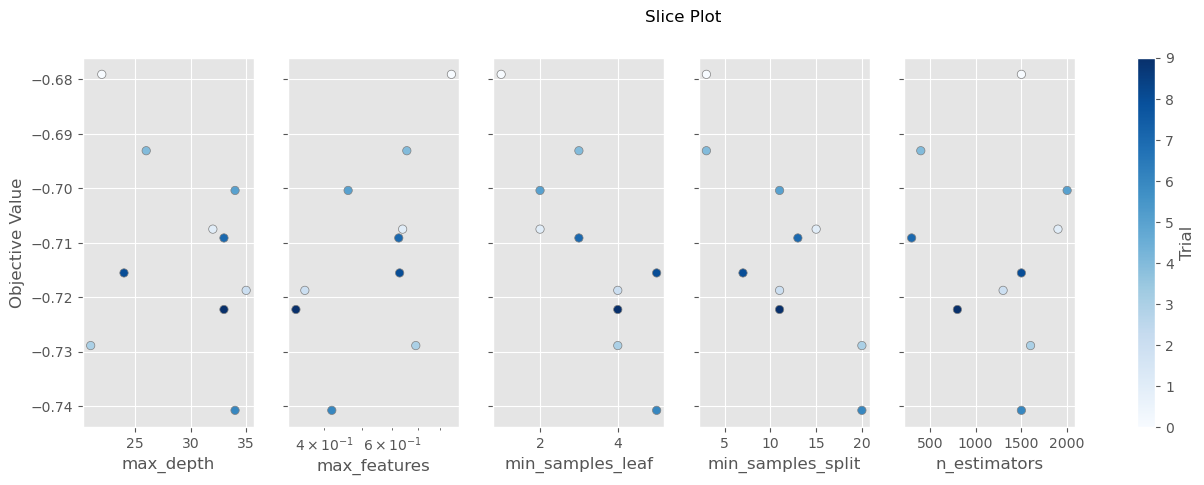

In [19]:
from optuna.visualization.matplotlib import plot_slice
import matplotlib.pyplot as plt

ax  = plot_slice(best_study)
plt.show()

In [ ]:
best_et_params = dict(
    bootstrap      = False,
    random_state   = RANDOM_STATE,
    **study.best_params,              # n_estimators, max_features, …
)

best_pipe = Pipeline([
    ("prep", make_preprocessor()),
    ("rf",    ExtraTreesWithUncertainty(sigma_min=0.01, **best_et_params)),
])

best_pipe.fit(X, y)
save_model(best_pipe, name="rf-runtime-pipeline-zscore")
save_optuna(best_study)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.base import clone


def plot_runtime_scatter_sklearn(pipe,
                                 X, y_log10,
                                 n_folds=10,
                                 lower=1e-4, upper=1e4,
                                 figsize=(6, 6),
                                 random_state=1234):
    """
    Cross‑validated true‑vs‑predicted runtime plot (seconds, log–log).

    Works for any scikit‑learn estimator or Pipeline, including your
      make_preprocessor ➜ ExtraTreesWithUncertainty combo.

    Parameters
    ----------
    pipe      : unfitted (or fitted) scikit‑learn estimator / Pipeline
    X         : pandas DataFrame or ndarray, shape (n_samples, n_features)
    y_log10   : array‑like, shape (n_samples,)
                Target already in log10 seconds.
    """

    # ------------------------------------------------------------------
    # 1. run k‑fold CV manually (avoids cross_val_predict restrictions)
    # ------------------------------------------------------------------
    kf         = KFold(n_splits=n_folds, shuffle=True,
                       random_state=random_state)
    y_pred_log = np.empty_like(y_log10, dtype=float)

    X_np = X.to_numpy(dtype=float, copy=False) if isinstance(X, pd.DataFrame) \
           else np.asarray(X, dtype=float)
    y_np = np.asarray(y_log10, dtype=float)

    for train_idx, test_idx in kf.split(X_np):
        model = clone(pipe)
        model.fit(X_np[train_idx], y_np[train_idx])
        y_pred_log[test_idx] = model.predict(X_np[test_idx])

    # ------------------------------------------------------------------
    # 2. convert to seconds for the plot
    # ------------------------------------------------------------------
    y_true_sec = 10 ** y_np
    y_pred_sec = 10 ** y_pred_log

    inside  = (y_pred_sec >= lower) & (y_pred_sec <= upper)
    outside = ~inside

    # ------------------------------------------------------------------
    # 3. plotting
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(y_true_sec[inside],  y_pred_sec[inside],
               s=18, alpha=0.6, edgecolor="k")
    ax.scatter(y_true_sec[outside],
               np.clip(y_pred_sec[outside], lower, upper),
               s=18, alpha=0.6, edgecolor="k", marker="x", color="tab:blue")

    ax.plot([lower, upper], [lower, upper],
            linestyle="--", linewidth=1.0, color="red")

    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls)
    ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(f"True vs. predicted runtimes ({n_folds}-fold CV)")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    return fig, ax


In [ ]:
fig, ax = plot_runtime_scatter_sklearn(best_pipe, X, y, n_folds=10)
plt.show()